In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=38841db6773880d6a734ca17fae8f8ee1e072ce9bc9869dd5ec8cb36b154086d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [3]:
data = yf.download(tickers = '^RUI', start = '2012-03-11',end = '2022-07-10')
data.head(10)

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

data_set = data.iloc[:, 0:11]
pd.set_option('display.max_columns', None)

data_set.head(20)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-af8595bcb83f>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,791.440002,795.679993,789.760010,789.760010,46.877256,795.406526,775.179523,762.677734,-2.690002,0,787.179993
1,789.869995,792.669983,785.640015,787.179993,44.575540,794.623046,775.417156,763.002267,6.260010,1,793.440002
2,787.179993,794.020020,786.260010,793.440002,50.849388,794.510376,775.774044,763.405416,7.019958,1,801.599976
3,794.580017,801.859985,794.580017,801.599976,57.558969,795.185576,776.285448,763.911304,4.369995,1,805.039978
4,800.669983,805.770020,800.669983,805.039978,60.023875,796.124090,776.854845,764.456055,-0.809998,0,803.330017
5,804.140015,806.770020,800.780029,803.330017,58.222935,796.810369,777.379106,764.970942,-12.209961,0,790.340027
6,802.549988,802.549988,788.549988,790.340027,46.795154,796.194146,777.635758,765.306956,0.830017,1,790.429993
7,789.599976,791.450012,784.169983,790.429993,46.872532,795.645179,777.889109,765.639712,-8.400024,0,779.619995
8,788.020020,788.020020,775.929993,779.619995,39.480532,794.118971,777.923384,765.824881,-4.059998,0,777.270020
9,781.330017,783.530029,776.349976,777.270020,38.081714,792.514309,777.910446,765.976472,-0.340027,0,779.429993


In [4]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

X = []
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)



splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

[[0.02295817 0.02294337 0.02477161 ... 0.61254467 0.         0.02075971]
 [0.02213767 0.02137597 0.02261574 ... 0.64462357 1.         0.02403152]
 [0.02073185 0.02207898 0.02294016 ... 0.6473474  1.         0.02829634]
 ...
 [0.70292872 0.70530315 0.68624737 ... 0.63741923 1.         0.71234811]
 [0.71004135 0.71485848 0.70603747 ... 0.72379951 1.         0.73006085]
 [0.7151577  0.72731964 0.71872676 ... 0.62397837 1.         0.72869667]]
2448
[[[2.29581669e-02 2.29433745e-02 2.47716068e-02 ... 1.38101972e-02
   8.97234280e-05 0.00000000e+00]
  [2.21376684e-02 2.13759713e-02 2.26157378e-02 ... 1.33872827e-02
   2.23202774e-04 1.85785313e-04]
  [2.07318516e-02 2.20789762e-02 2.29401625e-02 ... 1.33264641e-02
   4.23668073e-04 4.16575636e-04]
  ...
  [1.03842190e-02 9.06593181e-03 1.25061612e-02 ... 0.00000000e+00
   0.00000000e+00 2.21429917e-03]
  [1.22865199e-02 1.41534449e-02 1.49655357e-02 ... 4.61538131e-04
   4.20465674e-05 2.30721567e-03]
  [1.57200584e-02 1.35233817e-02 1.58550

In [5]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 8.7480e-05 - val_loss: 0.0013
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 7.7723e-05 - val_loss: 0.0013
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.6491e-05 - val_loss: 0.0012
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.1286e-05 - val_loss: 0.0012
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 8.5319e-05 - val_loss: 0.0012
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.7679e-05 - val_loss: 0.0012
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 9.5481e-05 - val_loss: 0.0011
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 7.5139e-05 - val_loss: 0.0012
Epoch 10/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 8.3475e-05 - val_loss: 0.0011
Epoch 11/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.4802e-05 - val_loss: 0.0011


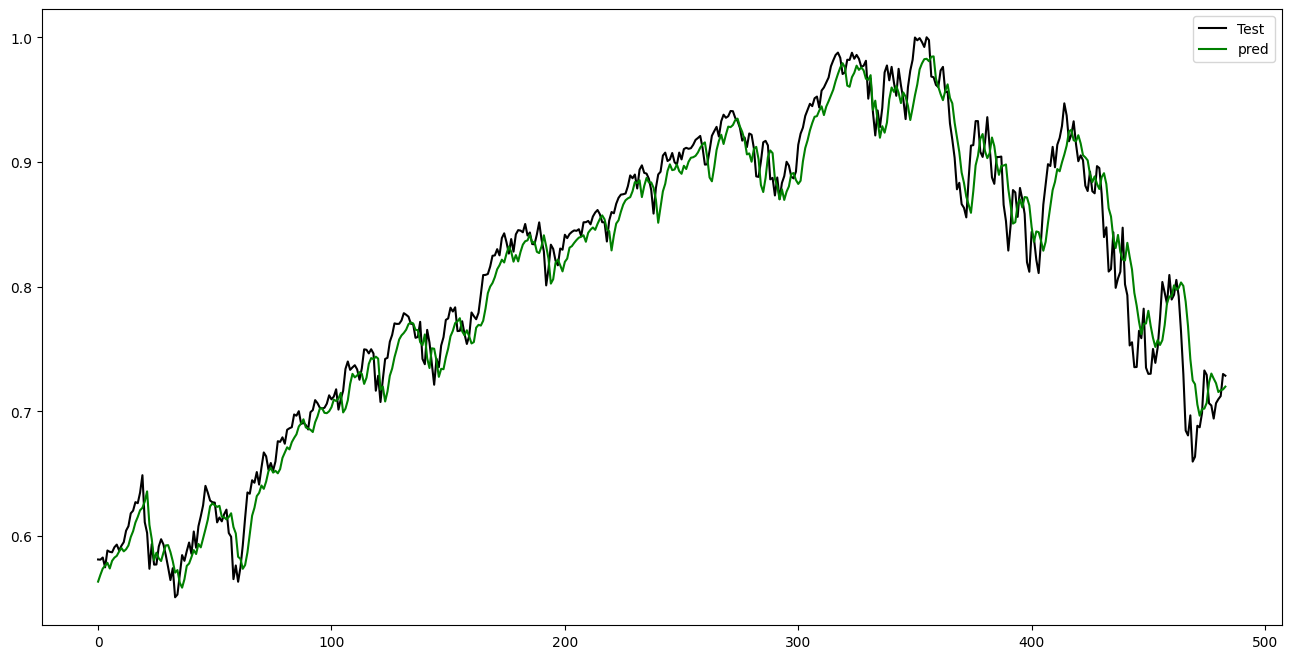

In [6]:
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mse)
print(rmse)

plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()